In [1]:
import os
import sys

root_folder = os.path.abspath(os.path.dirname(os.getcwd()))
sys.path.append(root_folder)

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib widget

from dynamics.quadrotor import QuadModel, ocp_no_obstacle_avoidance, ocp_obstacle_avoidance, check_koz_constraint, obs_positions, obs_radii
from optimization.quad_scenario import n_obs, n_time_rpod
import decision_transformer.manage as DT_manager
from dynamics.QuadEnv import QuadEnv
import time
from decision_transformer.art_closed_loop import AutonomousQuadrotorTransformerMPC, ConvexMPC, MyopicConvexMPC#, TwoPointsBoundaryValueProblemMPC, IterativeSequentialConvexProgrammingMPC


cpu


/home/davide.celestini/Transformer/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
# Simulation configuration
transformer_model_name = 'checkpoint_quad_random_forest_ctgrtg' #'checkpoint_rtn_v11'/'checkpoint_rtn_v01'
transformer_config = DT_manager.transformer_import_config(transformer_model_name)
mdp_constr = transformer_config['mdp_constr']
timestep_norm = transformer_config['timestep_norm']
dataset_scenario = transformer_config['dataset_scenario']
transformer_ws = 'dyn'
datasets, dataloaders = DT_manager.get_train_val_test_data(mdp_constr=mdp_constr, dataset_scenario=dataset_scenario, timestep_norm=timestep_norm)
train_dataset, val_dataset, test_dataset = datasets
train_loader, eval_loader, test_loader = dataloaders

Loading data from root/dataset/random_target_forest/torch/...Completed, DATA IS NOT SHUFFLED YET.



In [3]:
import torch
state_init = np.array([-1.9, 0.3, 0.26, 0, 0, 0])
state_final = np.array([0.4, 0.01, 0.35, 0, 0, 0])
test_sample = next(iter(test_loader))
data_stats = test_loader.dataset.data_stats
test_sample[0][0,:,:] = (torch.tensor(np.repeat(state_init[None,:], 100, axis=0)) - data_stats['states_mean'])/(data_stats['states_std'] + 1e-6)#(torch.tensor(xs[:-1,:]) - data_stats['states_mean'])/(data_stats['states_std'] + 1e-6)#
test_sample[1][0,:,:] = torch.zeros((100,3))#(torch.tensor(us) - data_stats['actions_mean'])/(data_stats['actions_std'] + 1e-6)#
test_sample[2][0,:,0] = torch.zeros((100,))#torch.from_numpy(compute_reward_to_go(test_sample[1][0,:,:]))#
test_sample[3][0,:,0] = torch.zeros((100,))#torch.from_numpy(compute_constraint_to_go(test_sample[0][0,:,:].cpu().numpy(), obs_positions, obs_radii))#
test_sample[4][0,:,:] = (torch.tensor(np.repeat(state_final[None,:], 100, axis=0)) - data_stats['goal_mean'])/(data_stats['goal_std'] + 1e-6)

In [4]:

select_idx = True # set to True to manually select a test trajectory via its index (idx)
idx = 4765 # index of the test trajectory (e.g., dx = 654) 3987 35998
# Sample from test dataset
if select_idx:
    test_sample = test_loader.dataset.getix(idx)
else:
    test_sample = next(iter(test_loader))
if mdp_constr:
    states_i, actions_i, rtgs_i, ctgs_i, goal_i, timesteps_i, attention_mask_i, dt, time_sec, ix = test_sample
else:
    states_i, actions_i, rtgs_i, goal_i, timesteps_i, attention_mask_i, dt, time_sec, ix = test_sample
print('Sampled trajectory ' + str(ix) + ' from test_dataset.')
data_stats = test_loader.dataset.data_stats
state_init = (test_sample[0][0,0,:] * data_stats['states_std'][0]) + (data_stats['states_mean'][0])
state_final = (test_sample[4][0,0,:] * data_stats['goal_std'][0]) + (data_stats['goal_mean'][0])

# QuadModel
qm = QuadModel(verbose=True)
dt = dt.item()
time_sec = np.hstack((time_sec[0,0], time_sec[0,0,-1] + dt))

Sampled trajectory [4765] from test_dataset.
Initializing drone class.


optimal
optimal
optimal
CVX cost: 0.027082942256032787
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
SCP cost: 0.05177963753580495
J vect [1.20221372e-01 5.37285867e-02 5.27713156e-02 5.23513590e-02
 5.20169697e-02 5.19100622e-02 5.18520406e-02 5.18195463e-02
 5.18013560e-02 5.17911958e-02 5.17855298e-02 5.17823734e-02
 5.17806158e-02 5.17796375e-02 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12]
GPT size: 11.1M parameters
Using ART model ' checkpoint_quad_random_forest_ctgrtg ' with inference function DT_manage.torch_model_inference_dyn()
ART cost: 0.0437493696808815
ART runtime: 1.1246325969696045
optimal
optimal
optimal
optimal
SCP cost: 0.0432427572565688
J vect [4.34164904e-02 4.32594131e-02 4.32433671e-02 4.32427573e-02
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1

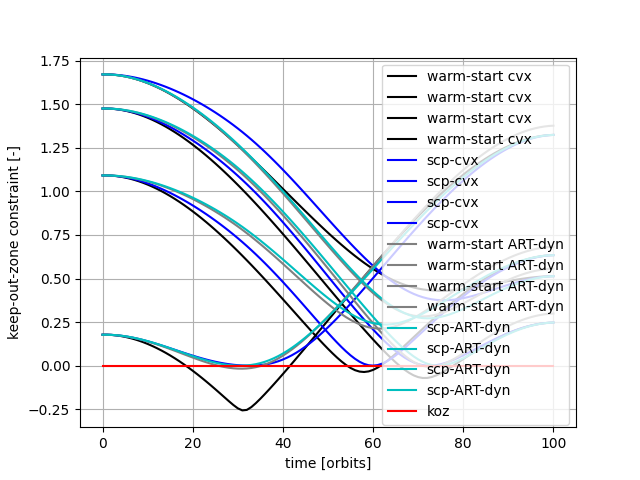

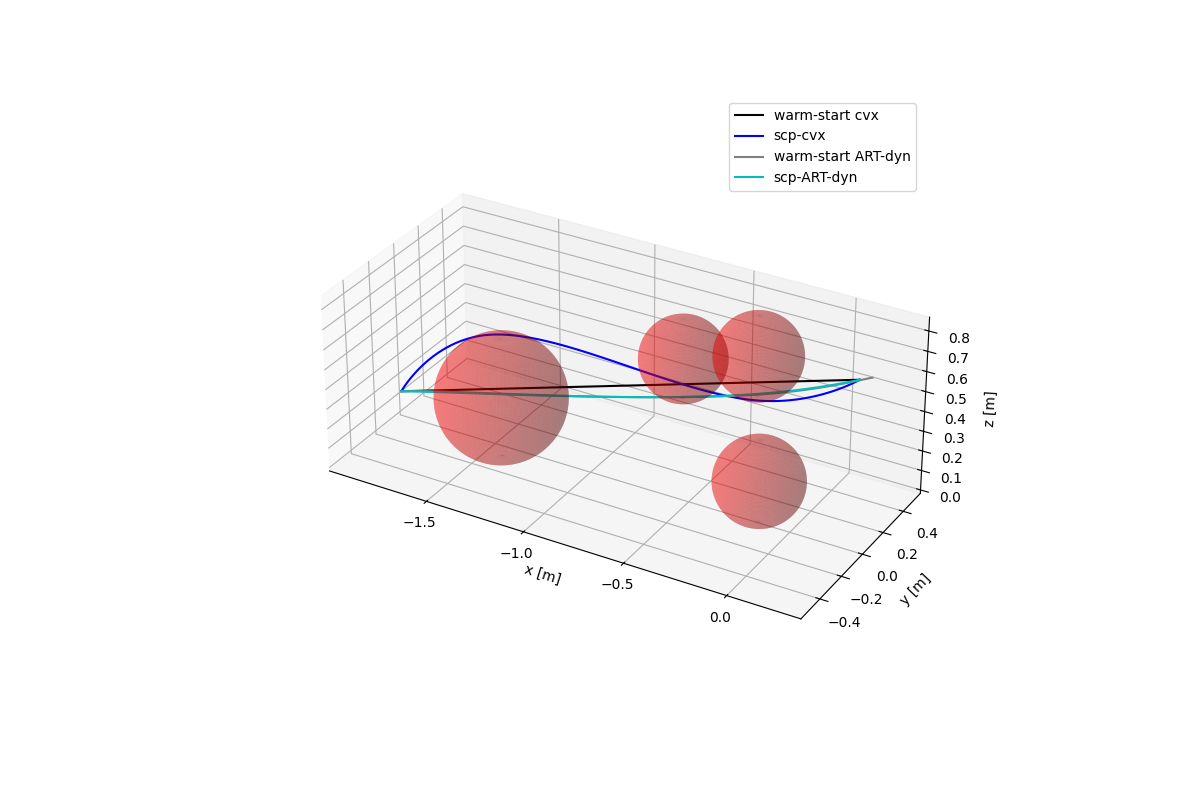

In [5]:
# Warmstarting and optimization
# Solve Convex Problem
states_ws_cvx, actions_ws_cvx, _, feas_cvx = ocp_no_obstacle_avoidance(qm, state_init, state_final, initial_guess='line')
states_ws_cvx = states_ws_cvx.T
actions_ws_cvx = actions_ws_cvx.T
print('CVX cost:', np.sum(la.norm(actions_ws_cvx, axis=0)**2)/2)
constr_cvx, constr_viol_cvx= check_koz_constraint(states_ws_cvx.T, obs_positions, obs_radii)
# Solve SCP
states_scp_cvx, actions_scp_cvx, J_vect_scp_cvx, feas_scp_cvx, iter_scp_cvx = ocp_obstacle_avoidance(qm, states_ws_cvx.T, actions_ws_cvx.T, state_init, state_final)
states_scp_cvx = states_scp_cvx.T
actions_scp_cvx = actions_scp_cvx.T
print('SCP cost:', np.sum(la.norm(actions_scp_cvx, axis=0)**2)/2)
print('J vect', J_vect_scp_cvx)
constr_scp_cvx, constr_viol_scp_cvx = check_koz_constraint(states_scp_cvx.T, obs_positions, obs_radii)

# Import the Transformer
model = DT_manager.get_DT_model(transformer_model_name, train_loader, eval_loader)
model.eval()
inference_func = getattr(DT_manager, 'torch_model_inference_'+transformer_ws)
print('Using ART model \'', transformer_model_name, '\' with inference function DT_manage.'+inference_func.__name__+'()')
rtg = - np.sum(la.norm(actions_ws_cvx, axis=0)**2)/2 if mdp_constr else None #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
DT_trajectory, runtime_DT = inference_func(model, test_loader, test_sample, rtg_perc=1., ctg_perc=0., rtg=rtg)
states_ws_DT = np.append(DT_trajectory['xyz_' + transformer_ws], (DT_trajectory['xyz_' + transformer_ws][:,-1] + qm.f(DT_trajectory['xyz_' + transformer_ws][:, -1], DT_trajectory['dv_' + transformer_ws][:, -1])*dt).reshape((6,1)), 1)# set warm start
actions_ws_DT = DT_trajectory['dv_' + transformer_ws]
print('ART cost:', np.sum(la.norm(actions_ws_DT, axis=0)**2)/2)
print('ART runtime:', runtime_DT)
constr_DT, constr_viol_DT = check_koz_constraint(states_ws_DT.T, obs_positions, obs_radii)

# Solve SCP
states_scp_DT, actions_scp_DT, J_vect_scp_DT, feas_scp_DT, iter_scp_DT = ocp_obstacle_avoidance(qm, states_ws_DT.T, actions_ws_DT.T, state_init, state_final)
states_scp_DT = states_scp_DT.T
actions_scp_DT = actions_scp_DT.T
print('SCP cost:', np.sum(la.norm(actions_scp_DT, axis=0)**2)/2)
print('J vect', J_vect_scp_DT)
constr_scp_DT, constr_viol_scp_DT = check_koz_constraint(states_scp_DT.T, obs_positions, obs_radii)

# Plotting

# 3D position trajectory
ax = plt.figure(figsize=(12,8)).add_subplot(projection='3d')
p1 = ax.plot3D(states_ws_cvx[0,:], states_ws_cvx[1,:], states_ws_cvx[2,:], 'k', linewidth=1.5, label='warm-start cvx')
p2 = ax.plot3D(states_scp_cvx[0,:], states_scp_cvx[1,:], states_scp_cvx[2,:], 'b', linewidth=1.5, label='scp-cvx')
p3 = ax.plot3D(states_ws_DT[0,:], states_ws_DT[1,:], states_ws_DT[2,:], c=[0.5,0.5,0.5], linewidth=1.5, label='warm-start ART-' + transformer_ws)
p4 = ax.plot3D(states_scp_DT[0,:], states_scp_DT[1,:], states_scp_DT[2,:], 'c', linewidth=1.5, label='scp-ART-' + transformer_ws)

for i in range(n_obs):
    p = obs_positions[i]
    r = obs_radii[i]
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = p[0] + r * np.outer(np.cos(u), np.sin(v))
    y = p[1] + r * np.outer(np.sin(u), np.sin(v))
    z = p[2] + r * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='r', linewidth=0, alpha=0.3)
ax.set_xlabel('x [m]', fontsize=10)
ax.set_ylabel('y [m]', fontsize=10)
ax.set_zlabel('z [m]', fontsize=10)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
ax.set_aspect('equal')
plt.savefig(root_folder + '/optimization/saved_files/plots/pos_3d.png')

# Constraint satisfaction
plt.figure()
plt.plot(time_sec, constr_cvx.T, 'k', linewidth=1.5, label='warm-start cvx')
plt.plot(time_sec, constr_scp_cvx.T, 'b', linewidth=1.5, label='scp-cvx')
plt.plot(time_sec, constr_DT.T, c=[0.5,0.5,0.5], linewidth=1.5, label='warm-start ART-' + transformer_ws)
plt.plot(time_sec, constr_scp_DT.T, 'c', linewidth=1.5, label='scp-ART-' + transformer_ws)
plt.plot(time_sec, np.zeros(n_time_rpod+1), 'r-', linewidth=1.5, label='koz')
plt.xlabel('time [orbits]', fontsize=10)
plt.ylabel('keep-out-zone constraint [-]', fontsize=10)
plt.grid(True)
plt.legend(loc='best', fontsize=10)
plt.savefig(root_folder + '/optimization/saved_files/plots/constr.png')

plt.show()

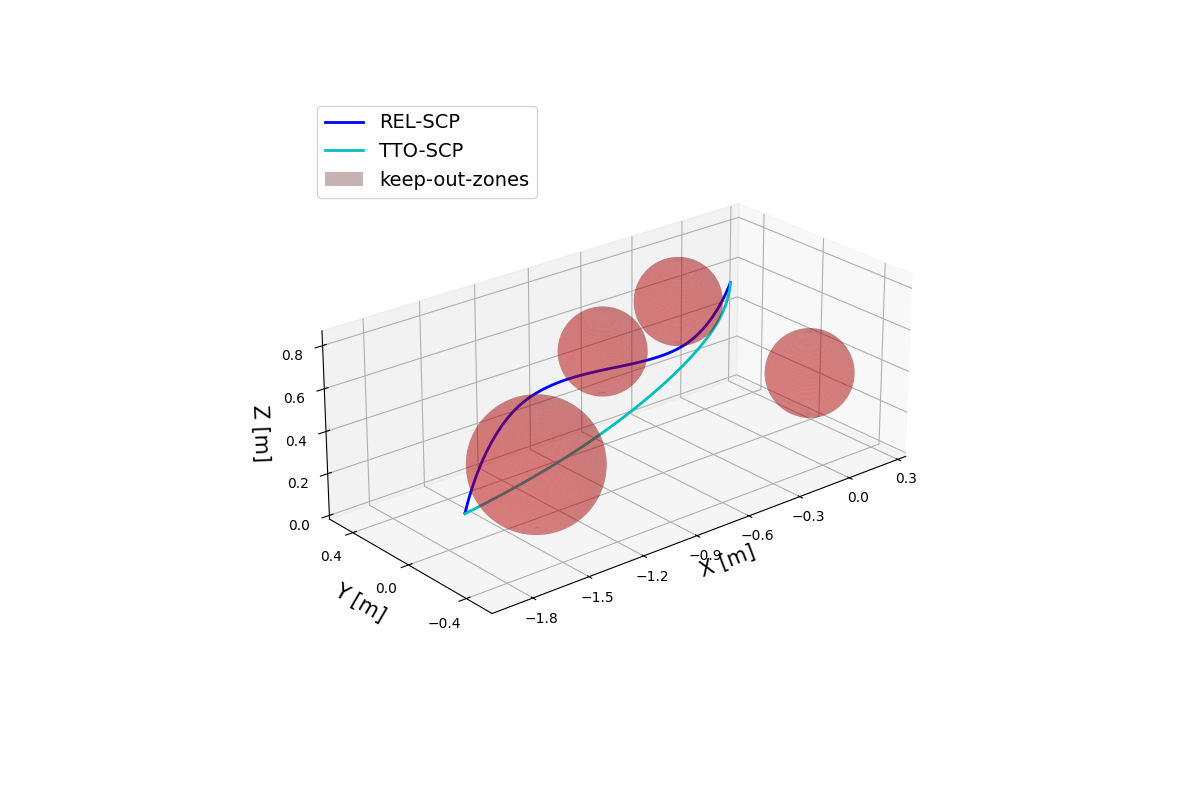

In [8]:
# 3D position trajectory
ax = plt.figure(figsize=(12,8)).add_subplot(projection='3d')
#p1 = ax.plot3D(states_ws_cvx[0,:], states_ws_cvx[1,:], states_ws_cvx[2,:], 'k', linewidth=1.5, label='warm-start cvx')
p2 = ax.plot3D(states_scp_cvx[0,:], states_scp_cvx[1,:], states_scp_cvx[2,:], 'b', linewidth=2, label='REL-SCP')
#p3 = ax.plot3D(states_ws_DT[0,:], states_ws_DT[1,:], states_ws_DT[2,:], c=[0.5,0.5,0.5], linewidth=1.5, label='warm-start ART-' + transformer_ws)
p4 = ax.plot3D(states_scp_DT[0,:], states_scp_DT[1,:], states_scp_DT[2,:], 'c', linewidth=2, label='TTO-SCP')

for i in range(n_obs):
    p = obs_positions[i]
    r = obs_radii[i]
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = p[0] + r * np.outer(np.cos(u), np.sin(v))
    y = p[1] + r * np.outer(np.sin(u), np.sin(v))
    z = p[2] + r * np.outer(np.ones(np.size(u)), np.cos(v))
    if i == 0:
        ax.plot_surface(x, y, z, rstride=1, cstride=1, color='r', linewidth=0, alpha=0.3, label='keep-out-zones')
    else:
        ax.plot_surface(x, y, z, rstride=1, cstride=1, color='r', linewidth=0, alpha=0.3)
ax.set_xlabel('X [m]', fontsize=15)
ax.set_ylabel('Y [m]', fontsize=15)
ax.set_zlabel('Z [m]', fontsize=15)
ax.set_xticks([-1.8, -1.5, -1.2, -0.9, -0.6, -0.3, 0, 0.3])
ax.set_yticks([-0.4, 0, 0.4])
ax.set_zticks([0,0.2,0.4,0.6,0.8])
ax.grid(True)
ax.set_aspect('equal')
ax.view_init(azim=-130, elev=24)
ax.legend(loc='upper left', fontsize=14)
plt.savefig('quad_forest_scenario.svg')

In [ ]:
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time_sec, states_ws_cvx[j,:], 'k-', linewidth=1.5, label='CVX')
    plt.plot(time_sec, states_scp_cvx[j,:], 'b-', linewidth=1.5, label='scp-CVX')
    plt.plot(time_sec, states_ws_DT[j,:], 'grey', linewidth=1.5, label='ART')
    plt.plot(time_sec, states_scp_DT[j,:], 'c-', linewidth=1.5, label='scp-ART')
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \delta r_r$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta r_t$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta r_n$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

# velocity vs time
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time_sec, states_ws_cvx[j+3,:], 'k-', linewidth=1.5, label='CVX')
    plt.plot(time_sec, states_scp_cvx[j+3,:], 'b-', linewidth=1.5, label='scp-CVX')
    plt.plot(time_sec, states_ws_DT[j+3,:], 'grey', linewidth=1.5, label='ART')
    plt.plot(time_sec, states_scp_DT[j+3,:], 'c-', linewidth=1.5, label='scp-ART')
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \delta v_r$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta v_t$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta v_n$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()
###### DELTA-V

# components
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.stem(time_sec[:-1], actions_ws_cvx[j,:]*1000., linefmt='k', markerfmt='ko', label='CVX')
    plt.stem(time_sec[:-1], actions_scp_cvx[j,:]*1000, linefmt='b', markerfmt='bo', label='scp-CVX')
    plt.stem(time_sec[:-1], actions_ws_DT[j,:]*1000., linefmt='grey', markerfmt='o', label='ART')
    plt.stem(time_sec[:-1], actions_scp_DT[j,:]*1000, linefmt='c', markerfmt='o', label='scp-ART')
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

In [ ]:
quad_env_art = QuadEnv(dataset_scenario)
quad_env_cvx = QuadEnv(dataset_scenario)
traj_sample = (dt, state_init, state_final)
quad_env_art.reset('det',traj_sample)
quad_env_cvx.reset('det',traj_sample)
aqt_cl = AutonomousQuadrotorTransformerMPC(model,test_loader,100,transformer_mode='dyn',ctg_clipped=True,scp_mode='soft')
'''oracle_cl = ConvexMPC(100,scp_mode='soft')'''
cvx_cl = ConvexMPC(100,scp_mode='soft')
'''art_cl = IterativeSequentialConvexProgrammingMPC('art', model, test_loader,scp_mode='soft')
cvx_cl = IterativeSequentialConvexProgrammingMPC('cvx',scp_mode='soft')
cvx_cl = MyopicConvexMPC(100,scp_mode='soft')
cvx_cl = TwoPointsBoundaryValueProblemMPC(100,scp_mode='soft')'''

In [ ]:
time_ARTMPC = np.empty((actions_ws_DT.shape[1],))
time_CVXMPC = np.empty((actions_ws_DT.shape[1],))
time_myo_CVXMPC = np.empty((actions_ws_DT.shape[1],))
flag = 'all'

for i in np.arange(actions_ws_DT.shape[1]):
    print(i)
    if flag == 'art' or flag == 'all':
        # ART-ws
        current_obs_art = quad_env_art.get_observation()
        tic = time.time()
        if mdp_constr:
            ART_traj = aqt_cl.warmstart(current_obs_art, quad_env_art, rtg0=rtg, ctg0=0)
        else:
            ART_traj = aqt_cl.warmstart(current_obs_art, quad_env_art, rtgs_i=rtgs_i)
        ARTMPC_traj, ARTMPC_scp_dict = aqt_cl.solve_scp(current_obs_art, quad_env_art, ART_traj['state'], ART_traj['dv'])
        time_ARTMPC[i] = time.time() - tic
        '''print('oracle')
        oracle_traj, stm, cim, psi = oracle_cl.warmstart(current_obs_art, rpod_env_art, return_dynamics=True)
        oracleMPC_traj, oracleMPC_scp_dict = oracle_cl.solve_scp(current_obs_art, rpod_env_art, stm, cim, psi, oracle_traj['state_roe'], oracle_traj['dv_rtn'])'''
        quad_env_art.load_prediction(ART_traj, ARTMPC_traj)
        _ = quad_env_art.step(ARTMPC_traj['dv'][:,0])
    
    if flag == 'cvx' or flag == 'all':
        #CVX-ws
        current_obs_cvx = quad_env_cvx.get_observation()
        tic = time.time()
        CVX_traj = cvx_cl.warmstart(current_obs_cvx, quad_env_cvx)
        CVXMPC_traj, CVXMPC_scp_dict = cvx_cl.solve_scp(current_obs_cvx, quad_env_cvx, CVX_traj['state'], CVX_traj['dv'])
        time_CVXMPC[i] = time.time() - tic
        quad_env_cvx.load_prediction(CVX_traj, CVXMPC_traj)
        _ = quad_env_cvx.step(CVXMPC_traj['dv'][:,0])


In [ ]:
from ipywidgets import interact
maneuver_dict_art = {
    'state_ART' : states_ws_DT,
    'state_scpART' : states_scp_DT,
    'time' : time_sec
}
fig_art, ax_art = quad_env_art.plot(maneuver=maneuver_dict_art, mpc_label='ART')
#plt.close()
maneuver_dict_cvx = {
    'state_ART' : states_ws_cvx,
    'state_scpART' : states_scp_cvx,
    'time' : time_sec
}
fig_cvx, ax_cvx = quad_env_cvx.plot(maneuver=maneuver_dict_cvx, mpc_label='CVX')
#plt.close()

@interact(k=(0, 101))
def plot(k=0):
    if flag == 'art' or flag == 'all':
        history_dict_art = {
            'state' : quad_env_art.state[:,:k+1],
            'time' : quad_env_art.time[:k+1]
        }
        quad_env_art.plot(ax=ax_art, plan=(quad_env_art.pred_history[k] if k < quad_env_art.timestep else None), history=history_dict_art)
        fig_art.canvas.draw()

    if flag == 'cvx' or flag == 'all':
        history_dict_cvx = {
            'state' : quad_env_cvx.state[:,:k+1],
            'time' : quad_env_cvx.time[:k+1]
        }
        quad_env_cvx.plot(ax=ax_cvx, plan=(quad_env_cvx.pred_history[k] if k < quad_env_cvx.timestep else None), history=history_dict_cvx)
        fig_cvx.canvas.draw()

    #return fig_art

In [ ]:
from ipywidgets import interact
maneuver_dict_art = {
    'state_ART' : states_ws_DT,
    'state_scpART' : states_scp_DT,
    'time' : time_sec
}
fig_art, ax_art = quad_env_art.plot3D(maneuver=maneuver_dict_art, mpc_label='ART')
#plt.close()
maneuver_dict_cvx = {
    'state_ART' : states_ws_cvx,
    'state_scpART' : states_scp_cvx,
    'time' : time_sec
}
fig_cvx, ax_cvx = quad_env_cvx.plot3D(maneuver=maneuver_dict_cvx, mpc_label='CVX')
#plt.close()

flag = 'all'
@interact(k=(0, 101))
def plot(k=0):
    if flag == 'art' or flag == 'all':
        history_dict_art = {
            'state' : quad_env_art.state[:,:k+1],
            'time' : quad_env_art.time[:k+1]
        }
        quad_env_art.plot3D(ax=ax_art, plan=(quad_env_art.pred_history[k] if k < quad_env_art.timestep else None), history=history_dict_art)
        ax_art.set_aspect('equal')
        fig_art.canvas.draw()

    if flag == 'cvx' or flag == 'all':
        history_dict_cvx = {
            'state' : quad_env_cvx.state[:,:k+1],
            'time' : quad_env_cvx.time[:k+1]
        }
        quad_env_cvx.plot3D(ax=ax_cvx, plan=(quad_env_cvx.pred_history[k] if k < quad_env_cvx.timestep else None), history=history_dict_cvx)
        ax_cvx.set_aspect('equal')
        fig_cvx.canvas.draw()

'''maneuver_dict_art = {
    'state_ART' : states_ws_DT,
    'state_scpART' : states_scp_DT,
    'time' : time_sec
}
history_art = [{
            'state' : quad_env_art.state[:,:k+1],
            'time' : quad_env_art.time[:k+1]
        } for k in range(n_time_rpod+1)]
fig_art = quad_env_art.plot3D_plotly(maneuver=maneuver_dict_art, plan=quad_env_art.pred_history, history=history_art, mpc_label='ART')
fig_art.show()

maneuver_dict_cvx = {
    'state_ART' : states_ws_cvx,
    'state_scpART' : states_scp_cvx,
    'time' : time_sec
}
history_cvx = [{
            'state' : quad_env_cvx.state[:,:k+1],
            'time' : quad_env_cvx.time[:k+1]
        } for k in range(n_time_rpod+1)]
fig_cvx = quad_env_cvx.plot3D_plotly(maneuver=maneuver_dict_cvx, plan=quad_env_cvx.pred_history, history=history_cvx, mpc_label='CVX')
fig_cvx.show()'''

In [ ]:
# Timeseries to compare
time0 = time_sec#ART_traj['time_orb'][0]#
states0 = states_ws_DT#states_rtn_scp_cvx#ARTMPC_state_rtn#
time1 = time_sec#ART_traj['time_orb'][0]#
states1 = states_scp_DT#states_rtn_scp_cvx#ARTMPC_state_rtn#
time2 = quad_env_art.time#np.empty(0)#np.arange(rpod_env.timestep-1,100)#ART_traj['time_orb']#
states2 = quad_env_art.state#np.empty((6,0))#ARTMPC_traj['state_rtn']#ART_traj['state_rtn']#
time3 = quad_env_cvx.time#np.empty(0)#np.arange(rpod_env.timestep-1,100)#ART_traj['time_orb']#
states3 = quad_env_cvx.state#np.empty((6,0))#ART_traj['state_rtn']#ARTMPC_traj['state_rtn']#

plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time0, states0[j,:], 'k-', linewidth=1.5, label='ART')
    plt.plot(time1, states1[j,:], 'b-', linewidth=1.5, label='scp-ART')
    plt.plot(time2, states2[j,:], 'g--', linewidth=1.5, label='ARTMPC')
    plt.plot(time3, states3[j,:], 'c--', linewidth=1.5, label='CVXMPC')
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \delta r_r$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta r_t$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta r_n$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

# velocity vs time
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time0, states0[j+3,:], 'k-', linewidth=1.5, label='ART')
    plt.plot(time1, states1[j+3,:], 'b-', linewidth=1.5, label='scp-ART')
    plt.plot(time2, states2[j+3,:], 'g--', linewidth=1.5, label='ARTMPC')
    plt.plot(time3, states3[j+3,:], 'c--', linewidth=1.5, label='CVXMPC')
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \delta v_r$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta v_t$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta v_n$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

In [ ]:
###### DELTA-V
# Timeseries to compare
time0 = time_sec[:-1]#ART_traj['time_orb'][0]#
action0 = actions_ws_DT#ARTMPC_dv_rtn#
time1 = time_sec[:-1]#ART_traj['time_orb'][0]#
action1 = actions_scp_DT#ARTMPC_dv_rtn#
time2 = quad_env_art.time[:-1]#time_orb[0][:-1]#ART_traj['time_orb']#
action2 = quad_env_art.dv#ART_traj['dv_rtn']#
time3 = quad_env_art.time[:-1]#time_orb[0][:-1]#ART_traj['time_orb']#
action3 = quad_env_cvx.dv#ART_traj['dv_rtn']#

# components
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.stem(time0, action0[j,:]*1000., linefmt='k', markerfmt='ko', label='ART')
    plt.stem(time1, action1[j,:]*1000., linefmt='b', markerfmt='bo', label='scp-ART')
    plt.stem(time2, action2[j,:]*1000, linefmt='g', markerfmt='g^', label='ARTMPC')
    plt.stem(time3, action3[j,:]*1000, linefmt='c', markerfmt='c*', label='CVXMPC')
    
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v_r$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v_t$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v_n$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

In [ ]:
constr_ARTMPC, constr_viol_ARTMPC = check_koz_constraint(quad_env_art.state.T, quad_env_art.obs_positions, quad_env_art.obs_radii)
constr_CVXMPC, constr_viol_CVXMPC = check_koz_constraint(quad_env_cvx.state.T, quad_env_cvx.obs_positions, quad_env_cvx.obs_radii)

# Constraint satisfaction
plt.figure()
plt.plot(time_sec, constr_DT.T, 'k', linewidth=1.5, label='warm-start ART-' + transformer_ws)
plt.plot(time_sec, constr_scp_DT.T, 'b', linewidth=1.5, label='scp-ART-' + transformer_ws)
plt.plot(time_sec, constr_ARTMPC.T, 'g--', linewidth=1.5, label='ART-MPC')
plt.plot(time_sec, constr_CVXMPC.T, 'c--', linewidth=1.5, label='CVX-MPC')
plt.plot(time_sec, np.zeros(n_time_rpod+1), 'r-', linewidth=1.5, label='koz')
plt.xlabel('time [orbits]', fontsize=10)
plt.ylabel('keep-out-zone constraint [-]', fontsize=10)
plt.grid(True)
plt.legend(loc='best', fontsize=10)

In [ ]:
np.sum(np.linalg.norm(actions_scp_DT,axis=0)**2)/2

In [ ]:
print('ART-MPC cost', np.sum(np.linalg.norm(quad_env_art.dv,axis=0)**2)/2)
print('CVX-MPC cost', np.sum(np.linalg.norm(quad_env_cvx.dv,axis=0)**2)/2)
print('SCP open loop cost history', J_vect_scp_DT)

In [ ]:
plt.figure()
plt.plot(time_ARTMPC, label='ARTMPC')
plt.plot(time_CVXMPC, label='CVXMPC')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [ ]:
results = np.load('saved_files/closed_loop_analysis_checkpoint_rtn_ctgrtg_v02.npz')
results.allow_pickle = True
cost = results['cost'].item()
indexes = results['indexes']
count_eff = results['counter_eff']
